In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import random as rd
import statistics as stat

import warnings

import time
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
## Guassian kernel
def guassian(x,y,sigma):
    return np.exp(-np.linalg.norm(x-y)**2/(2*sigma**2))

## Random Fourier feature
def FRF(X,w,b):
    D=b.shape[0]
    z=np.matmul(w,X.T)+b.reshape(D,1)
    return (2/D)**0.5*np.cos(z).T

## 3 Adult
### 3.1 Import data

In [3]:
adult_train = pd.read_csv('adult.data', header=None, na_values=' ?')
adult_test = pd.read_csv('adult.test', header=None, na_values=' ?')
adult_data = pd.concat([adult_train, adult_test])

col=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
     'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
adult_data.columns=col
adult_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adult_data = adult_data.dropna()

In [5]:
adult_data.loc[(adult_data['income']==' <=50K.')|(adult_data['income']==' <=50K'),'income']=-1
adult_data.loc[(adult_data['income']==' >50K.')|(adult_data['income']==' >50K'),'income']=1

**one-hot encoding for categorical variables**

In [6]:
string_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex','education']
string_data = adult_data[string_columns]
print(string_data.shape)
#one_hot转换
string_data = pd.get_dummies(string_data)
print(string_data.shape)

string_data.head()

(45222, 7)
(45222, 57)


,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,...,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [7]:
#转换成numpy数组
string_data = string_data.values
print(string_data)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
col = ['age','capital-gain','capital-loss', 'hours-per-week']

adult=pd.DataFrame()
for i in col:
    variable=adult_data[i]
    # (x-min(x))/(max(x)-min(x))
    adult[i]=(variable-variable.min())/(variable.max()-variable.min())
print(adult.shape)
num_data=adult.iloc[:,:].values
print(num_data)

(45222, 4)
[[0.30136986 0.02174022 0.         0.39795918]
 [0.45205479 0.         0.         0.12244898]
 [0.28767123 0.         0.         0.39795918]
 ...
 [0.28767123 0.         0.         0.5       ]
 [0.36986301 0.05455055 0.         0.39795918]
 [0.24657534 0.         0.         0.60204082]]


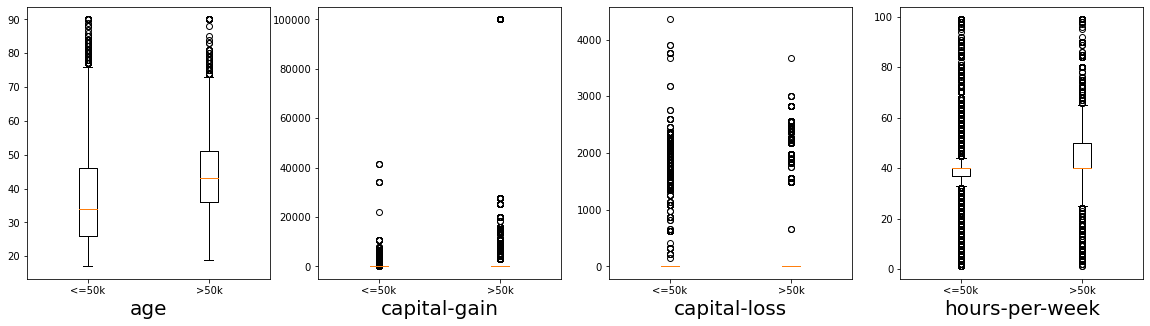

In [9]:
fig,ax=plt.subplots(1,4,figsize=(20,5))

for i in range(4):
    boxes=[adult_data[col[i]][adult_data['income']==-1],adult_data[col[i]][adult_data['income']==1]]
    ax[i].boxplot(boxes,notch=False, labels = ['<=50k','>50k'],patch_artist = False)
    ax[i].set_xlabel(col[i], fontsize=20)
    #ax[i//3,i-i//3*3].set_xlabel(CPU_col[i-1],fontsize=14)

In [10]:
X = np.append(string_data, num_data, axis=1);y=np.array(adult_data['income'])
train_length=32561
X_train = X[:train_length]
y_train = y[:train_length].astype('int')
X_test = X[train_length:]
y_test = y[train_length:].astype('int')
print(X.shape,y.shape)

(45222, 61) (45222,)


### Grid search

In [11]:
## grid search

param_grid = {'C':[0.01,0.1],'gamma':[1,0.1,0.01,0.001]}
grid = GridSearchCV(SVC(kernel='rbf'),param_grid,refit = True, verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.01, gamma=1 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. C=0.01, gamma=1, total=  49.1s
[CV] C=0.01, gamma=1 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.0s remaining:    0.0s


[CV] .................................. C=0.01, gamma=1, total=  48.6s
[CV] C=0.01, gamma=1 .................................................
[CV] .................................. C=0.01, gamma=1, total= 1.0min
[CV] C=0.01, gamma=1 .................................................
[CV] .................................. C=0.01, gamma=1, total=  48.9s
[CV] C=0.01, gamma=1 .................................................
[CV] .................................. C=0.01, gamma=1, total=  48.9s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................................ C=0.01, gamma=0.1, total=  32.2s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................................ C=0.01, gamma=0.1, total=  32.4s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................................ C=0.01, gamma=0.1, total=  32.9s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 26.0min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1], 'gamma': [1, 0.1, 0.001, 0.0001]},
             verbose=2)

In [12]:
grid.best_params_

{'C': 0.1, 'gamma': 0.1}

**Fourier Random feature**

In [21]:
timeu=[];i=0
while i <5:
    print(i)
    start_time=time.time()
    model1=SVC(kernel='rbf',C=0.1,gamma=0.1)
    model1.fit(X_train,y_train)
    timeu.append(time.time()-start_time)
    i=i+1
print('time used:',np.array(timeu).mean())
pre1=model1.predict(X_train);tre1=model1.predict(X_test)

print(classification_report(y_train,pre1))
print(classification_report(y_test,tre1))

0
1
2
3
4
time used: 38.50451588630676
              precision    recall  f1-score   support

          -1       0.85      0.93      0.89     24453
           1       0.72      0.51      0.60      8108

    accuracy                           0.83     32561
   macro avg       0.79      0.72      0.74     32561
weighted avg       0.82      0.83      0.82     32561

              precision    recall  f1-score   support

          -1       0.85      0.94      0.89      9561
           1       0.72      0.50      0.59      3100

    accuracy                           0.83     12661
   macro avg       0.79      0.72      0.74     12661
weighted avg       0.82      0.83      0.82     12661



In [11]:
model1=SVC(kernel='rbf',C=0.1,gamma=0.1)
model1.fit(X_train,y_train)
pre1=model1.predict(X_train);tre1=model1.predict(X_test)
classification_report(y_train,pre1).split( )[15]

'0.83'

In [14]:
Dnum=[10,50,100,500]
for j in range(4):
    print(j)
    timeu=[];precision=[[],[]];recall=[[],[]];f1=[[],[]];acsim=[[],[]]
    for i in range(50):
        N=Dnum[j]
        d=X.shape[1];mean=np.zeros(d);variance=np.eye(d)/5
        w=np.random.multivariate_normal(mean,variance,N)
        b=np.random.uniform(0,2*np.pi,N)
        X1_frf=FRF(X_train,w,b);T1_frf=FRF(X_test,w,b)
        start_time=time.time()
        model2=LinearSVC(C=0.1)
        model2.fit(X1_frf,y_train)
        timeu.append(time.time()-start_time)
        prelib=model2.predict(X1_frf);trelib=model2.predict(T1_frf)
        pr,re,f1x=classification_report(y_train,prelib).split( )[10:13];prt,ret,f1t=classification_report(y_test,trelib).split( )[10:13]
        precision[0].append(pr);precision[1].append(prt);recall[0].append(re);recall[1].append(ret);f1[0].append(f1x);f1[1].append(f1t)
        # model similarity
        ac=classification_report(pre1,prelib).split( )[15];act=classification_report(tre1,trelib).split( )[15]
        acsim[0].append(ac);acsim[1].append(act)
    print('time used:',np.array(timeu).mean())
    print('performance socre(train):',np.array(precision[0]).astype('float').mean(),np.array(recall[0]).astype('float').mean(),
          np.array(f1[0]).astype('float').mean())
    print('performance socre(test):',np.array(precision[1]).astype('float').mean(),np.array(recall[1]).astype('float').mean(),
          np.array(f1[1]).astype('float').mean())
    print('model similarity(train):',np.array(acsim[0]).astype('float').mean(),',(test):',np.array(acsim[1]).astype('float').mean())

0
time used: 0.04111174106597901
performance socre(train): 0.5763999999999999 0.19880000000000003 0.28300000000000003
performance socre(test): 0.5676 0.19480000000000003 0.2764
model similarity(train): 0.8548 ,(test): 0.8582000000000001
1
time used: 0.13557083606719972
performance socre(train): 0.6884000000000001 0.48340000000000005 0.5673999999999999
performance socre(test): 0.6874000000000001 0.47540000000000004 0.5628
model similarity(train): 0.9456 ,(test): 0.945
2
time used: 0.19536092281341552
performance socre(train): 0.7051999999999999 0.5268 0.6026
performance socre(test): 0.7044 0.519 0.5966
model similarity(train): 0.9574000000000001 ,(test): 0.9572000000000002
3
time used: 0.6484824991226197
performance socre(train): 0.7263999999999998 0.5673999999999999 0.6382000000000001
performance socre(test): 0.7202 0.5573999999999999 0.6297999999999999
model similarity(train): 0.9594000000000001 ,(test): 0.9582


In [15]:
# median adjustment
print(X_train.shape[1])
xmedian=np.array([stat.median(X_train[:,i]) for i in range(X_train.shape[1])]);print(xmedian)

61
[0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.2739726  0.         0.
 0.39795918]


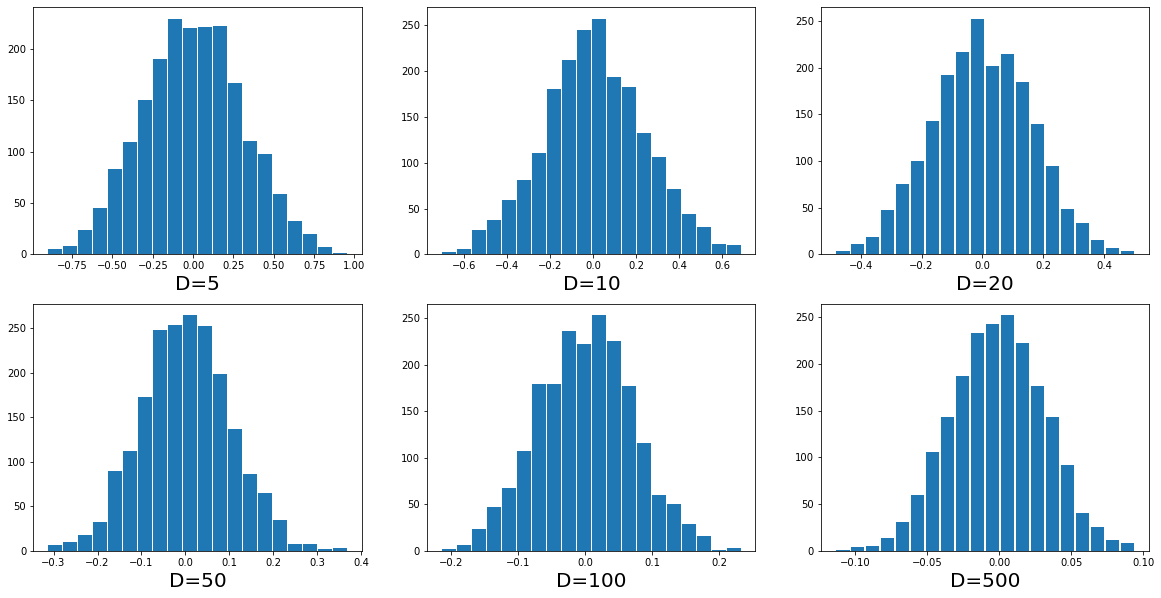

In [19]:
fig,ax=plt.subplots(2,3,figsize=(20,10));Dnum=[5,10,20,50,100,500]
for j in range(6):
    approz=[]
    for i in range(2000):
        N=Dnum[j]
        d=X.shape[1];mean=np.zeros(d);variance=np.eye(d)/5
        w=np.random.multivariate_normal(mean,variance,N)
        b=np.random.uniform(0,2*np.pi,N)
        z=np.matmul(xmedian,w.T)+b
        X_frf=(2/N)**0.5*np.cos(z)
        approz.append(np.matmul(X_frf,X_frf))
    ax[j//3,j-j//3*3].hist(np.array(approz)-1,rwidth=0.9,bins=20)
    ax[j//3,j-j//3*3].set_xlabel('D='+str(Dnum[j]),fontsize=20)

In [17]:
l=np.array([1,1,1,1]);we=[[],[],[],[]];np.random.seed(1)
while len(l[np.array([len(k)>=50 for k in we])])<4:
    d=X.shape[1];mean=np.zeros(d);variance=np.eye(d)/5
    w=np.random.multivariate_normal(mean,variance,50)
    b=np.random.uniform(0,2*np.pi,50)
    z=np.matmul(xmedian,w.T)+b
    X_frf=(2/50)**0.5*np.cos(z)
    if np.abs(np.matmul(X_frf,X_frf)-1)<0.08 and np.abs(np.matmul(X_frf,X_frf)-1)>0:
        # small error of median
        we[0].append([w,b,np.matmul(X_frf,X_frf)-1])
    elif np.abs(np.matmul(X_frf,X_frf)-1)<0.16 and np.abs(np.matmul(X_frf,X_frf)-1)>0.08:
        # large error of median
        we[1].append([w,b,np.matmul(X_frf,X_frf)-1])
    elif np.abs(np.matmul(X_frf,X_frf)-1)<0.24 and np.abs(np.matmul(X_frf,X_frf)-1)>0.16:
        # large error of median
        we[2].append([w,b,np.matmul(X_frf,X_frf)-1])
    elif np.abs(np.matmul(X_frf,X_frf)-1)>0.24:
        # large error of median
        we[3].append([w,b,np.matmul(X_frf,X_frf)-1])
    
par=[p[:50] for p in we]

In [18]:
for j in range(4):
    print(j)
    timeu=[];precision=[[],[]];recall=[[],[]];f1=[[],[]];acsim=[[],[]]
    for i in range(50):
        w,b,e=par[j][i]
        X1_frf=FRF(X_train,w,b);T1_frf=FRF(X_test,w,b)
        start_time=time.time()
        model2=LinearSVC(C=0.1)
        model2.fit(X1_frf,y_train)
        timeu.append(time.time()-start_time)
        prelib=model2.predict(X1_frf);trelib=model2.predict(T1_frf)
        pr,re,f1x=classification_report(y_train,prelib).split( )[10:13];prt,ret,f1t=classification_report(y_test,trelib).split( )[10:13]
        precision[0].append(pr);precision[1].append(prt);recall[0].append(re);recall[1].append(ret);f1[0].append(f1x);f1[1].append(f1t)
        # model similarity
        ac=classification_report(pre1,prelib).split( )[15];act=classification_report(tre1,trelib).split( )[15]
        acsim[0].append(ac);acsim[1].append(act)
    print('time used:',np.array(timeu).mean())
    print('performance socre(train):',np.array(precision[0]).astype('float').mean(),np.array(recall[0]).astype('float').mean(),
          np.array(f1[0]).astype('float').mean())
    print('performance socre(test):',np.array(precision[1]).astype('float').mean(),np.array(recall[1]).astype('float').mean(),
          np.array(f1[1]).astype('float').mean())
    print('model similarity(train):',np.array(acsim[0]).astype('float').mean(),',(test):',np.array(acsim[1]).astype('float').mean())

0
time used: 0.18183727741241454
performance socre(train): 0.6880000000000002 0.48260000000000003 0.5670000000000001
performance socre(test): 0.6870000000000002 0.475 0.5616
model similarity(train): 0.9438 ,(test): 0.9445999999999999
1
time used: 0.17790653705596923
performance socre(train): 0.6873999999999999 0.48700000000000004 0.5696
performance socre(test): 0.6857999999999999 0.48039999999999994 0.5638000000000001
model similarity(train): 0.9432000000000003 ,(test): 0.9436000000000001
2
time used: 0.17014212608337403
performance socre(train): 0.6868 0.4830000000000001 0.5668
performance socre(test): 0.6833999999999999 0.474 0.5596
model similarity(train): 0.9438 ,(test): 0.9436
3
time used: 0.17135676860809326
performance socre(train): 0.6866 0.47700000000000004 0.5624
performance socre(test): 0.6839999999999999 0.46980000000000005 0.557
model similarity(train): 0.9411999999999999 ,(test): 0.9411999999999999


0
1
2
3
4
5


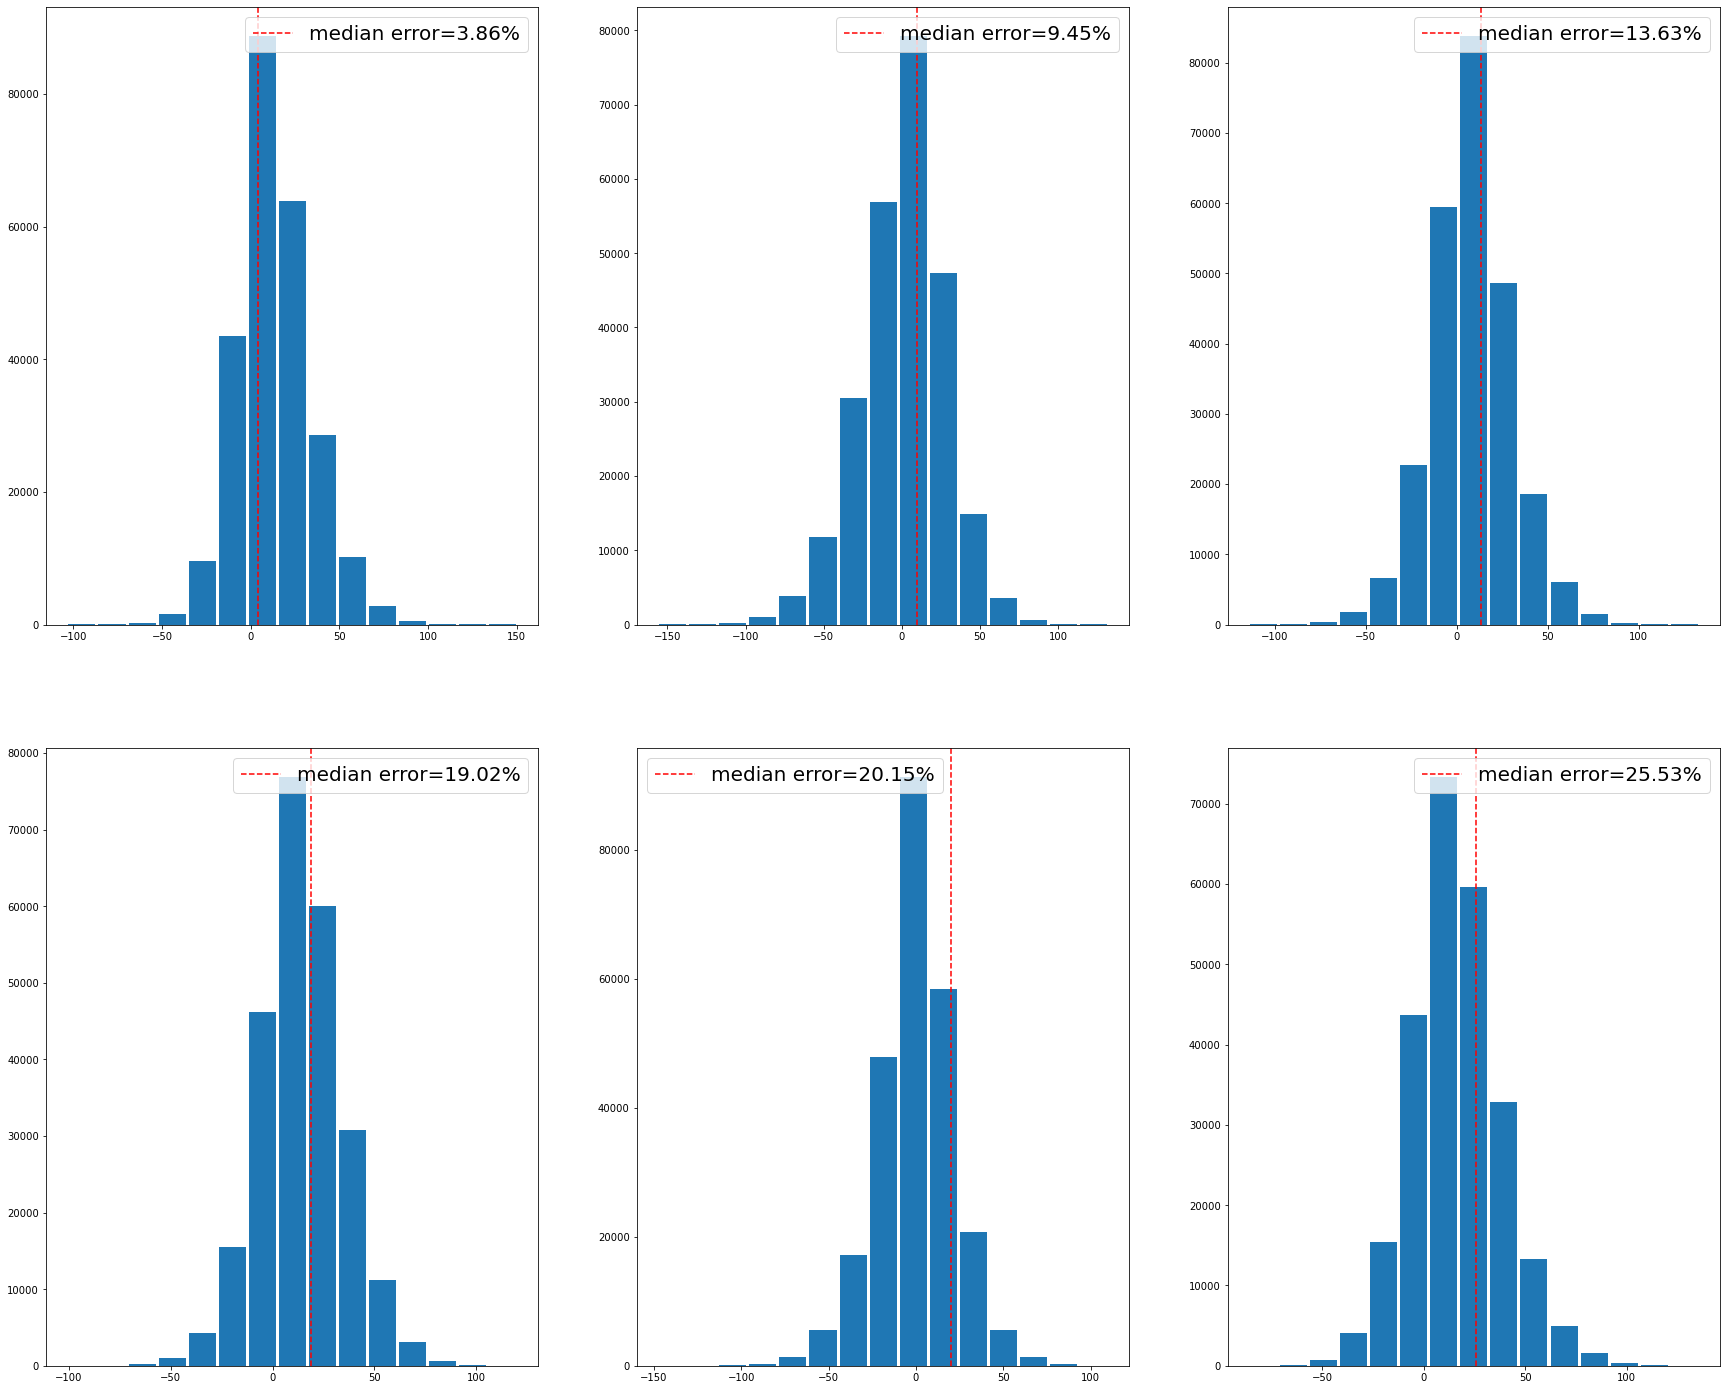

In [30]:
rd.seed(123);sigma=5**0.5;np.random.seed(1)
xi=rd.sample([*range(X_train.shape[0])],500)
## kernel of x_train
gauX=np.array([[guassian(X_train[i],X_train[j],sigma)for i in xi] for j in xi]).ravel()

fig,ax=plt.subplots(2,3,figsize=(30,25))
we=[[] for i in range(6)];l=np.array([1 for i in range(6)])
d=X.shape[1];mean=np.zeros(d);variance=np.eye(d)/5
while len(l[np.array([len(k)>=1 for k in we])])<6:
    w=np.random.multivariate_normal(mean,variance,100)
    b=np.random.uniform(0,2*np.pi,100)
    z=np.matmul(xmedian,w.T)+b
    X_frf=(2/100)**0.5*np.cos(z)
    if np.matmul(X_frf,X_frf)-1<0.05 and np.matmul(X_frf,X_frf)-1>0:
        # small error of median
        we[0].append([w,b,np.matmul(X_frf,X_frf)-1])
    elif np.matmul(X_frf,X_frf)-1<0.1 and np.matmul(X_frf,X_frf)-1>0.05:
        # large error of median
        we[1].append([w,b,np.matmul(X_frf,X_frf)-1])
    elif np.matmul(X_frf,X_frf)-1<0.15 and np.matmul(X_frf,X_frf)-1>0.1:
        # large error of median
        we[2].append([w,b,np.matmul(X_frf,X_frf)-1])
    elif np.matmul(X_frf,X_frf)-1<0.2 and np.matmul(X_frf,X_frf)-1>0.15:
        # large error of median
        we[3].append([w,b,np.matmul(X_frf,X_frf)-1])
    elif np.matmul(X_frf,X_frf)-1<0.25 and np.matmul(X_frf,X_frf)-1>0.2:
        # large error of median
        we[4].append([w,b,np.matmul(X_frf,X_frf)-1])
    elif np.matmul(X_frf,X_frf)-1<0.3 and np.matmul(X_frf,X_frf)-1>0.25:
        # large error of median
        we[5].append([w,b,np.matmul(X_frf,X_frf)-1])

wlist=[];blist=[];erlist=[]
for i in range(6):
    # find small error w,b
    print(i)
    ## random fourier feature approximate
    X_frf=FRF(X_train,we[i][0][0],we[i][0][1])
    frfX=np.array([[np.matmul(X_frf[i],X_frf[j]) for i in xi] for j in xi]).ravel()
    
    ax[i//3,i-i//3*3].hist(100*(frfX-gauX)/gauX,rwidth=0.9,bins=15)
    ax[i//3,i-i//3*3].axvline(x=100*we[i][0][2],linestyle='--',label='median error='+str(round(100*we[i][0][2],2))+'%',c='red')
    ax[i//3,i-i//3*3].legend(fontsize=20)
    wlist.append(we[i][0][0]);blist.append(we[i][0][1]);erlist.append(we[i][0][2])
    
    
plt.show()

In [19]:
num_feature = X_train.shape[1]
with open('svmlight_train_adult.txt','w') as f:
    for i in range(train_length):
        label = str(y_train[i])
        
        feature_pair = ''
        for index in range(num_feature):
            feature_pair = feature_pair + ' '+str(index+1)+':'+str(X_train[i][index])
            
        sample = label + feature_pair+'\n'
        f.writelines(sample)

In [22]:
with open('svmlight_test_adult.txt','w') as f:
    for i in range(X_test.shape[0]):
        label = str(y_test[i])
        
        feature_pair = ''
        for index in range(num_feature):
            feature_pair = feature_pair + ' '+str(index+1)+':'+str(X_test[i][index])
            
        sample = label + feature_pair+'\n'
        f.writelines(sample)

In [27]:
# SVMlight -z:classify,-c: C=0.1, -t:rbf kernel, -g: gamma=0.1
!svm_learn.exe -z c -c 0.1 -t 2 -g 0.1 svmlight_train_adult.txt

!svm_classify.exe svmlight_train_adult.txt svm_model train_adult.txt

!svm_classify.exe svmlight_test_adult.txt svm_model test_adult.txt

Scanning examples...done
Reading examples into memory...100..200..300..400..500..600..700..800..900..1000..1100..1200..1300..1400..1500..1600..1700..1800..1900..2000..2100..2200..2300..2400..2500..2600..2700..2800..2900..3000..3100..3200..3300..3400..3500..3600..3700..3800..3900..4000..4100..4200..4300..4400..4500..4600..4700..4800..4900..5000..5100..5200..5300..5400..5500..5600..5700..5800..5900..6000..6100..6200..6300..6400..6500..6600..6700..6800..6900..7000..7100..7200..7300..7400..7500..7600..7700..7800..7900..8000..8100..8200..8300..8400..8500..8600..8700..8800..8900..9000..9100..9200..9300..9400..9500..9600..9700..9800..9900..10000..10100..10200..10300..10400..10500..10600..10700..10800..10900..11000..11100..11200..11300..11400..11500..11600..11700..11800..11900..12000..12100..12200..12300..12400..12500..12600..12700..12800..12900..13000..13100..13200..13300..13400..13500..13600..13700..13800..13900..14000..14100..14200..14300..14400..14500..14600..14700..14800..14900..15000..15

Reading model...OK. (12925 support vectors read)
Classifying test examples..100..200..300..400..500..600..700..800..900..1000..1100..1200..1300..1400..1500..1600..1700..1800..1900..2000..2100..2200..2300..2400..2500..2600..2700..2800..2900..3000..3100..3200..3300..3400..3500..3600..3700..3800..3900..4000..4100..4200..4300..4400..4500..4600..4700..4800..4900..5000..5100..5200..5300..5400..5500..5600..5700..5800..5900..6000..6100..6200..6300..6400..6500..6600..6700..6800..6900..7000..7100..7200..7300..7400..7500..7600..7700..7800..7900..8000..8100..8200..8300..8400..8500..8600..8700..8800..8900..9000..9100..9200..9300..9400..9500..9600..9700..9800..9900..10000..10100..10200..10300..10400..10500..10600..10700..10800..10900..11000..11100..11200..11300..11400..11500..11600..11700..11800..11900..12000..12100..12200..12300..12400..12500..12600..12700..12800..12900..13000..13100..13200..13300..13400..13500..13600..13700..13800..13900..14000..14100..14200..14300..14400..14500..14600..14700..148